# Tutorial: Sequential Monte Carlo in Gen

In [1]:
using Gen
using Pkg
Pkg.status()

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1190


    Status `~/dev/gen-examples/Project.toml`
  [ea4f424c] ~ Gen v0.2.1 #master (https://github.com/probcomp/Gen) ⇒ v0.2.1 [`~/dev/Gen`]
  [1956f2fc]   GenTF v0.1.0 #master (https://github.com/probcomp/GenTF)
  [5a9e95f6]   GenViz v0.1.0 #master (https://github.com/probcomp/GenViz)
  [7073ff75]   IJulia v1.15.2
  [4138dd39]   JLD v0.9.1
  [eb30cadb]   MLDatasets v0.3.0
  [438e738f]   PyCall v1.18.5
  [d330b81b]   PyPlot v2.7.0
  [2913bbd2]   StatsBase v0.27.0
  [9a3f8284]   Random 
  [10745b16]   Statistics 


In [2]:
methods(Gen.initialize_particle_filter)

# 2 methods for generic function "initialize_particle_filter":
[1] initialize_particle_filter(model::GenerativeFunction{T,U}, model_args::Tuple, observations::Assignment, proposal::GenerativeFunction, proposal_args::Tuple, num_particles::Int64) where {T, U} in Gen at /home/marcoct/dev/Gen/src/inference/particle_filter.jl:67
[2] initialize_particle_filter(model::GenerativeFunction{T,U}, model_args::Tuple, observations::Assignment, num_particles::Int64) where {T, U} in Gen at /home/marcoct/dev/Gen/src/inference/particle_filter.jl:86

In [3]:
using PyPlot

In [18]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

In [4]:
import Random
Random.seed!(1);

## Original model, not using unfold combinator

In [ ]:
function x_mean(x_prev::Real, t::Int)
    (x_prev / 2.) + 25 * (x_prev / (1 + x_prev * x_prev)) + 8 * cos(1.2 * t)
end

y_mean(x::Real) = (x * x / 20.)

@gen function hmm(var_x::Float64, var_y::Float64, T::Int)
    xs = Vector{Float64}(undef, T)
    ys = Vector{Float64}(undef, T)
    xs[1] = @addr(normal(0, 5), (:x, 1))
    ys[1] = @addr(normal(y_mean(xs[1]), sqrt(var_y)), (:y, 1))
    for t=2:T
        xs[t] = @addr(normal(x_mean(xs[t-1], t), sqrt(var_x)), (:x, t))
        ys[t] = @addr(normal(y_mean(xs[t]), sqrt(var_y)), (:y, t))
    end 
    return (xs, ys) 
end;

Trace rendering for original model

In [ ]:
function render_trace(trace; show_data=true)
    (xs, ys) = get_retval(trace)
    subplot(2, 1, 1)
    plot(xs, color="black")
    if show_data
        subplot(2, 1, 2)
        plot(ys, color="red");
    end
end;

Generate a synthetic data set:

In [ ]:
trace, _ = initialize(hmm, (10., 1., 100))
(xs, ys) = get_retval(trace)
figure(figsize=(16, 4))
render_trace(trace);

## Improved model, with unfold combinator

In [ ]:
@gen function kernel(t::Int, prev_x::Float64, var_x::Float64, var_y::Float64)
    x = @addr(normal(x_mean(prev_x, t), sqrt(var_x)), :x)
    y = @addr(normal(y_mean(x), sqrt(var_y)), :y)
    return x
end

chain = Unfold(kernel);

@gen function unfold_hmm(var_x::Float64, var_y::Float64, T::Int)
    @diff chain_argdiff = @argdiff()
    init_x = @addr(normal(0, 5), :init_x)
    @addr(normal(y_mean(init_x), sqrt(var_y)), :init_y)
    @addr(chain(T-1, init_x, var_x, var_y), :chain, chain_argdiff)
end;

trace rendering for unfold model

In [ ]:
function render_trace_for_unfold(trace; show_data=true)
    choices = get_assmt(trace)
    T = get_args(trace)[3]
    xs = Vector{Float64}(undef, T)
    ys = Vector{Float64}(undef, T)
    xs[1] = choices[:init_x]
    ys[1] = choices[:init_y]
    for t=2:T
        xs[t] = choices[:chain => t-1 => :x]
        ys[t] = choices[:chain => t-1 => :y]
    end
    subplot(2, 1, 1)
    plot(xs, color="black")
    if show_data
        subplot(2, 1, 2)
        plot(ys, color="red");
    end
end;

# generic particle filter implementation

In [ ]:
mutable struct ParticleFilterState{U}
    traces::Vector{U}
    new_traces::Vector{U}
    log_weights::Vector{Float64}
    log_ml_est::Float64
    parents::Vector{Int}
end

function initialize_particle_filter(model::GenerativeFunction{T,U}, model_args::Tuple,
        observations::Assignment, proposal::GenerativeFunction, proposal_args::Tuple,
        num_particles::Int) where {T,U}
    traces = Vector{Any}(undef, num_particles)
    log_weights = Vector{Float64}(undef, num_particles)
    for i=1:num_particles
        (prop_choices, prop_weight, _) = Gen.propose(proposal, proposal_args)
        (traces[i], model_weight) = Gen.initialize(model, model_args, merge(observations, prop_choices))
        log_weights[i] = model_weight - prop_weight
    end
    return ParticleFilterState{U}(traces, Vector{U}(undef, num_particles), log_weights, 0., collect(1:num_particles))
end

function particle_filter_step!(state::ParticleFilterState{U}, new_args::Tuple, argdiff,
        observations::Assignment, proposal::GenerativeFunction, proposal_args::Tuple) where {U}
    num_particles = length(state.traces)
    for i=1:num_particles
        choices = Gen.get_assmt(state.traces[i])
        (prop_choices, prop_weight, _) = Gen.propose(proposal, (state.traces[i], proposal_args...))
        constraints = merge(observations, prop_choices)
        (state.new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, argdiff, state.traces[i], constraints)
        @assert isempty(disc)
        state.log_weights[i] += up_weight - prop_weight
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp
    
    return nothing
end

import Distributions

function effective_sample_size(log_normalized_weights::Vector{Float64})
    log_ess = -logsumexp(2. * log_normalized_weights)
    return exp(log_ess)
end

function normalize_weights(log_weights::Vector{Float64})
    log_total_weight = logsumexp(log_weights)
    log_normalized_weights = log_weights .- log_total_weight
    return (log_total_weight, log_normalized_weights)
end

function maybe_resample!(state::ParticleFilterState{U};
                        ess_threshold::Float64=length(state.traces)/2, verbose=false) where {U}
    num_particles = length(state.traces)
    (log_total_weight, log_normalized_weights) = normalize_weights(state.log_weights)
    ess = effective_sample_size(log_normalized_weights)
    do_resample = ess < ess_threshold
    if verbose
        println("effective sample size: $ess, doing resample: $do_resample")
    end
    if do_resample
        weights = exp.(log_normalized_weights)
        Distributions.rand!(Distributions.Categorical(weights / sum(weights)), state.parents)
        state.log_ml_est += log_total_weight - log(num_particles)
        for i=1:num_particles
            state.new_traces[i] = state.traces[state.parents[i]]
            state.log_weights[i] = 0.
        end
        
        # swap references
        tmp = state.traces
        state.traces = state.new_traces
        state.new_traces = tmp
    end
    return do_resample
end

function log_ml_estimate(state::ParticleFilterState)
    num_particles = length(state.traces)
    return state.log_ml_est + logsumexp(state.log_weights) - log(num_particles)
end;

## Particle filtering for unfold model

proposals for particle filter with unfold

In [ ]:
@gen function unfold_init_proposal()
    @addr(normal(0, 5), :init_x)
end

@gen function unfold_step_proposal(prev_trace, t::Int)
    @assert t > 1
    var_x = Gen.get_args(prev_trace)[1]
    x_prev = Gen.get_assmt(prev_trace)[t > 2 ? (:chain => t-2 => :x) : :init_x]
    @addr(normal(x_mean(x_prev, t), sqrt(var_x)), :chain => t-1 => :x)
end;

the actual particle filter code

In [ ]:
function unfold_particle_filter(var_x::Float64, var_y::Float64, ys::Vector{Float64}, num_particles::Int)
    init_obs = DynamicAssignment((:init_y, ys[1]))
    state = initialize_particle_filter(unfold_hmm, (var_x, var_y, 1), init_obs,
        unfold_init_proposal, (), num_particles)
    for T=2:length(ys)
        y = ys[T]
        step_obs = DynamicAssignment((:chain => T-1 => :y, y))
        new_args = (var_x, var_y, T)
        particle_filter_step!(state, new_args, UnfoldCustomArgDiff(false, false),
            step_obs, unfold_step_proposal, (T,))
        did_resample = maybe_resample!(state)
    end
    return state
end;

run it

In [ ]:
state = unfold_particle_filter(10., 1., ys, 1000);

show the traces

In [ ]:
figure(figsize=(16, 4))
render_trace(trace);

In [17]:


figure(figsize=(16,4))
overlay(render_trace_for_unfold, state.traces, same_data=true)

UndefVarError: UndefVarError: render_trace_for_unfold not defined

## Adding rejuvenation moves



In [ ]:
@gen function rejuvenation_move_proposal(prev_trace)
    T::Int = Gen.get_args(prev_trace)[3]
    choices = Gen.get_assmt(prev_trace)
    # jointly propose a change to the last 3 x values
    if T > 3
        # if T=2, we want to propose a change to (1) :init_x and (2) :chain => 1 => :x
        # if T=3, we want to propose a change to (1) :chain => 2 => x and (3) :chain => 3 => :x
        # if T=4, we want to propose a change to (1) :chain => 3 => x and (3) :chain => 4 => :x
        for j=0:2
            @addr(normal(choices[:chain => (T-1) - j => :x], 0.5), :chain => (T-1) - j => :x)
        end
    else
        @addr(normal(choices[:init_x], 0.5), :init_x)
    end
end

function unfold_particle_filter_with_rejuv(var_x::Float64, var_y::Float64, ys::Vector{Float64}, num_particles::Int)
    init_obs = DynamicAssignment((:init_y, ys[1]))
    state = initialize_particle_filter(unfold_hmm, (var_x, var_y, 1), init_obs,
        unfold_init_proposal, (), num_particles)
    for T=2:length(ys)
        # rejuvenation moves
        for i=1:num_particles
            for j=1:10
                (state.traces[i], _) = metropolis_hastings(state.traces[i], rejuvenation_move_proposal, ())
            end
        end
        y = ys[T]
        step_obs = DynamicAssignment((:chain => T-1 => :y, y))
        new_args = (var_x, var_y, T)
        particle_filter_step!(state, new_args, UnfoldCustomArgDiff(false, false),
            step_obs, unfold_step_proposal, (T,))
        did_resample = maybe_resample!(state)
    end
    return state
end;

In [ ]:
state_rejuv = unfold_particle_filter_with_rejuv(10., 1., ys, 1000);

In [ ]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

figure(figsize=(16,4))
overlay(render_trace_for_unfold, state_rejuv.traces, same_data=true)

In [ ]:
figure(figsize=(16, 4))
render_trace(trace);

static version:

In [ ]:
@gen (static) function static_kernel(t::Int, prev_x::Float64, var_x::Float64, var_y::Float64)
    x::Float64 = @addr(normal(x_mean(prev_x, t), sqrt(var_x)), :x)
    y::Float64 = @addr(normal(y_mean(x), sqrt(var_y)), :y)
    return x
end

static_chain = Unfold(static_kernel);

@gen (static) function static_hmm_with_unfold(var_x::Float64, var_y::Float64, T::Int)
    @diff masked_argdiff = @argdiff()
    @diff chain_argdiff = masked_argdiff.argdiff
    init_x::Float64 = @addr(normal(0, 5), :init_x)
    init_y::Float64 = @addr(normal(y_mean(init_x), sqrt(var_y)), :init_y)
    @addr(static_chain(T-1, init_x, var_x, var_y), :chain, chain_argdiff)
end;

In [ ]:
Gen.get_ir(typeof(static_hmm_with_unfold)).call_nodes[1].argdiff

trace rendering for the model for unfold

proposal for use with unfold:

proposal for static model

In [ ]:
@gen (static) function static_proposal_sub(var_x::Float64, x_prev::Float64, t::Int)
    x::Float64 = @addr(normal(x_mean(x_prev, t), sqrt(var_x)), :x)
end

@gen (static) function static_proposal_for_unfold(prev_trace, t::Int)
    var_x = Gen.get_args(prev_trace)[1]
    x_prev = Gen.get_assmt(prev_trace)[t > 2 ? (:chain => t-2 => :x) : :init_x]
    key = t-1
    @addr(static_proposal_sub(var_x, x_prev, t), :chain => key) # TODO document this limitation
end;

In [ ]:
Gen.load_generated_functions()

a single step forward for the unfold model

In [ ]:
unfold_argdiff = UnfoldCustomArgDiff(false, false)

function step_forward_for_unfold(traces::Vector{T}, log_weights::Vector{Float64}, y::Float64, t::Int) where {T}
    @assert t > 1
    new_traces = Vector{T}(undef, length(traces))
    new_log_weights = copy(log_weights)
    observation = DynamicAssignment((:chain => t-1 => :y, y))
    args = Gen.get_args(traces[1])
    new_args = (args[1], args[2], t) # increment t
    for i=1:length(traces)
        @assert args[3] == t-1
        choices = Gen.get_assmt(traces[i])
        (prop_choices, prop_weight, _) = Gen.propose(proposal_for_unfold, (traces[i], t))
        constraints = merge(observation, prop_choices)
        (new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, unfold_argdiff, traces[i], constraints)
        @assert isempty(disc)
        new_log_weights[i] += up_weight - prop_weight
    end
    (new_traces, new_log_weights)
end;

static version:

In [ ]:
static_unfold_argdiff = MaskedArgDiff{Tuple{false,false,true}, UnfoldCustomArgDiff}(UnfoldCustomArgDiff(false, false))

function static_step_forward_for_unfold(traces::Vector{T}, log_weights::Vector{Float64}, y::Float64, t::Int) where {T}
    @assert t > 1
    new_traces = Vector{T}(undef, length(traces))
    new_log_weights = copy(log_weights)
    observation = DynamicAssignment((:chain => t-1 => :y, y))
    args = Gen.get_args(traces[1])
    new_args = (args[1], args[2], t) # increment t
    for i=1:length(traces)
        @assert args[3] == t-1
        choices = Gen.get_assmt(traces[i])
        (prop_choices, prop_weight, _) = Gen.propose(static_proposal_for_unfold, (traces[i], t))
        constraints = merge(observation, prop_choices)
        (new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, static_unfold_argdiff, traces[i], constraints)
        #println(disc)
        #@assert isempty(disc) # TODO
        new_log_weights[i] += up_weight - prop_weight
    end
    (new_traces, new_log_weights)
end;

getting the intial traces for the unfold model (using the prior as the proposal for :init_x)

In [ ]:
function get_initial_traces_for_unfold(var_x::Float64, var_y::Float64, n::Int, y1::Float64)
    traces = Vector{Any}(undef, n)
    log_weights = Vector{Float64}(undef, n)
    constraints = Gen.DynamicAssignment((:init_y, y1))
    for i=1:n
        (traces[i], log_weights[i]) = Gen.initialize(hmm_with_unfold, (var_x, var_y, 1), constraints)
    end
    (traces, log_weights)
end;

static version

In [ ]:
function static_get_initial_traces_for_unfold(var_x::Float64, var_y::Float64, n::Int, y1::Float64)
    traces = Vector{Any}(undef, n)
    log_weights = Vector{Float64}(undef, n)
    constraints = Gen.DynamicAssignment((:init_y, y1))
    for i=1:n
        (traces[i], log_weights[i]) = Gen.initialize(static_hmm_with_unfold, (var_x, var_y, 1), constraints)
    end
    (traces, log_weights)
end;

particle filtering for unfold model

In [ ]:
function do_particle_filter_for_unfold(ys::Vector{Float64}, num_particles)
    (traces, log_weights) = get_initial_traces_for_unfold(10., 1., num_particles, ys[1]);
    log_ml_est = 0.
    for t=2:length(ys)
        y = ys[t]
        (traces, log_weights) = step_forward_for_unfold(traces, log_weights, y, t)
        (traces, log_weights, incr) = maybe_resample(traces, log_weights)
        log_ml_est += incr
    end
    (traces, log_weights, log_ml_est)
end;

static version

In [ ]:
function static_do_particle_filter_for_unfold(ys::Vector{Float64}, num_particles)
    (traces, log_weights) = static_get_initial_traces_for_unfold(10., 1., num_particles, ys[1]);
    log_ml_est = 0.
    for t=2:length(ys)
        y = ys[t]
        (traces, log_weights) = static_step_forward_for_unfold(traces, log_weights, y, t)
        (traces, log_weights, incr) = maybe_resample(traces, log_weights)
        log_ml_est += incr
    end
    (traces, log_weights, log_ml_est)
end;

test it:


In [ ]:
function timing_experiment(ns::Vector{Int})
    times = Vector{Float64}()
    times_unfold = Vector{Float64}()
    times_static_unfold = Vector{Float64}()
    
    for n in ns
        
        tstart = time_ns()
        (traces, log_weights, log_ml_est) = do_particle_filter_for_unfold(ys[1:n], 1000)
        push!(times_unfold, (time_ns() - tstart) / 1e9)
        
        tstart = time_ns()
        (traces, log_weights, log_ml_est) = do_particle_filter(ys[1:n], 1000)
        push!(times, (time_ns() - tstart) / 1e9)
        
        tstart = time_ns()
        (traces, log_weights, log_ml_est) = static_do_particle_filter_for_unfold(ys[1:n], 1000)
        push!(times_static_unfold, (time_ns() - tstart) / 1e9)
    end
    (times, times_unfold, times_static_unfold)
end;

In [ ]:
println(methods(force_update))

In [ ]:
Gen.codegen_force_or_fix_update(
    Tuple{Float64,Float64,Int64},
    MaskedArgDiff{Tuple{false,false,true},UnfoldCustomArgDiff},
    Gen.get_trace_type(static_hmm_with_unfold),
    StaticAssignment{(),Tuple{},(:chain,),Tuple{DynamicAssignment}},
    Gen.ForceUpdateMode())

In [ ]:
ns = [1, 5, 10, 20, 30, 40]#, 50, 100, 150, 200]
(times, times_unfold, times_static_unfold) = timing_experiment(ns)

In [ ]:
plot(ns, times, color="blue")
plot(ns, times_unfold, color="red")
plot(ns, times_static_unfold, color="green")
xlabel("Number of time steps")
ylabel("Running time (sec.)");

## Particle filtering not using unfold

In [ ]:
(traces, log_weights, log_ml_est) = do_particle_filter(ys, 1000);

function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

figure(figsize=(16,4))
overlay(render_trace, traces, same_data=true)

In [ ]:
@gen function proposal(prev_trace, t::Int)
    var_x = Gen.get_args(prev_trace)[1]
    x_prev = Gen.get_assmt(prev_trace)[(:x, t-1)]
    @addr(normal(x_mean(x_prev, t), sqrt(var_x)), (:x, t))
end;

In [ ]:
function get_initial_traces(var_x::Float64, var_y::Float64, n::Int, y1::Float64)
    traces = Vector{Any}(undef, n)
    log_weights = Vector{Float64}(undef, n)
    constraints = Gen.DynamicAssignment(((:y, 1), y1))
    for i=1:n
        (traces[i], log_weights[i]) = Gen.initialize(hmm, (var_x, var_y, 1), constraints)
    end
    (traces, log_weights)
end;

In [ ]:
(traces, log_weights) = get_initial_traces(10., 1., 1000, 0.5);

In [ ]:
function step_forward(traces::Vector{T}, log_weights::Vector{Float64}, y::Float64, t::Int) where {T}
    @assert t > 1
    new_traces = Vector{T}(undef, length(traces))
    new_log_weights = copy(log_weights)
    observation = DynamicAssignment(((:y, t), y))
    args = Gen.get_args(traces[1])
    new_args = (args[1], args[2], t) # increment t
    for i=1:length(traces)
        @assert args[3] == t-1
        choices = Gen.get_assmt(traces[i])
        x_prev, y_prev = (choices[(:x, t-1)], choices[(:y, t-1)])
        (prop_choices, prop_weight, _) = Gen.propose(proposal, (traces[i], t))
        constraints = merge(observation, prop_choices)
        (new_traces[i], up_weight, disc, _) = Gen.force_update(new_args, Gen.unknownargdiff, traces[i], constraints)
        @assert isempty(disc)
        new_log_weights[i] += up_weight - prop_weight
    end
    (new_traces, new_log_weights)
end;

In [ ]:
function do_particle_filter(ys::Vector{Float64}, num_particles)
    (traces, log_weights) = get_initial_traces(10., 1., num_particles, ys[1]);
    log_ml_est = 0.
    for t=2:length(ys)
        y = ys[t]
        (traces, log_weights) = step_forward(traces, log_weights, y, t)
        (traces, log_weights, incr) = maybe_resample(traces, log_weights)
        log_ml_est += incr
    end
    (traces, log_weights, log_ml_est)
end;

In [ ]:
(traces, log_weights, log_ml_est) = do_particle_filter([1., 2., 1., 2., 1., 2., 1.], 10000);

## 2. Particle filtering with a default proposal

use the nonlinear state space model from the PMMH paper (with fixed global parameters)

## 3. Particle filtering with rejuvenation moves

in the nonlinear state space model from the PMMH paper, do rejuvenation moves on the global parameters?

## 4. Particle Marginal Metropolis Hastings

do PMMH in the nonlinear state space model

## 5. Particle filtering with a custom proposal

use the 'motion along path' model

compare the default and custom proposals

# Bearings only tracking

http://www.mathcs.emory.edu/~whalen/Papers/BNs/MonteCarlo-DBNs.pdf

In [210]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)
    
    # parameters
    measurement_noise = 0.005
    velocity_var = @addr(gamma(1., 0.00001), :velocity_var) # volatility in velocity Gamma(shape=1.0, rate=0.00001)
    
    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)
    zs = Vector{Float64}(undef, T+1)

    # prior on initial conditions
    x = @addr(normal(0.0108, 0.04), :x0)
    y = @addr(normal(1.03, 0.4), :y0)
    vx = @addr(normal(0.002, 0.003), :vx0)
    vy = @addr(normal(-0.013, 0.003), :vy0)

    # initial measurement
    zs[1] = @addr(normal(bearing(x, y), measurement_noise), :z0)

    xs[1] = x
    ys[1] = y    
    
    for t=1:T
        vx = @addr(normal(vx, sqrt(velocity_var)), (:vx, t))
        vy = @addr(normal(vy, sqrt(velocity_var)), (:vy, t))
        x += vx
        y += vy
        zs[t+1] = @addr(normal(bearing(x, y), measurement_noise), (:z, t))
        
        xs[t+1] = x
        ys[t+1] = y
    end
    
    return (xs, ys, zs)
end;

In [211]:
function render(trace; show_data=true, max_T=get_args(trace)[1])
    (T,) = Gen.get_args(trace)
    choices = Gen.get_assmt(trace)
    (xs, ys, zs) = Gen.get_retval(trace)
    scatter(xs[1:max_T+1], ys[1:max_T+1], s=5)
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot([0., dx], [0., dy], color="red", alpha=0.3)
        end
    end
end

render (generic function with 1 method)

generate a trajectory

In [212]:
import Random
Random.seed!(4)
x0 = 0.01
y0 = 0.95
vx0 = 0.002
vy0 = -0.013
tau = 1e6
constraints = DynamicAssignment((:x0, x0), (:y0, y0), (:vx0, vx0), (:vy0, vy0), (:velocity_var, 1.0/tau))
(trace, _) = initialize(model, (50,), constraints);

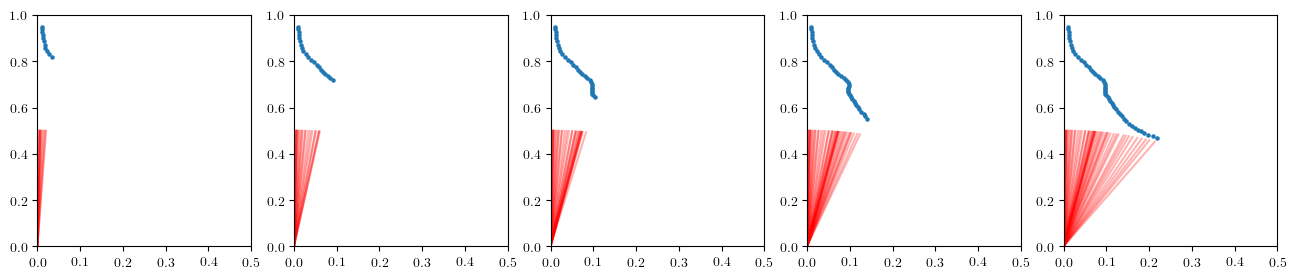

In [213]:
figure(figsize=(16, 3))
for (i, max_T) in enumerate([10, 20, 30, 40, 50])
    subplot(1, 5, i)
    render(trace, max_T=max_T)
    gca()[:set_xlim]((0, 0.5))
    gca()[:set_ylim]((0, 1))
end

In [214]:
(xs, ys, zs) = get_retval(trace);

Define importance sampler

In [221]:
function importance(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    obs = DynamicAssignment((:z0, zs[1]))
    for t=1:length(zs)-1
        obs[(:z, t)] = zs[t+1]
    end
    (traces, log_weights, _) = importance_sampling(model, (length(zs),), obs, num_particles)
    (_, log_normalized_weights) = Gen.normalize_weights(log_weights)
    weights = exp.(log_normalized_weights)
    return [traces[categorical(weights)] for _=1:num_samples]
end;

Define particle filter without rejuvenation

In [232]:
function pf(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = DynamicAssignment((:z0, zs[1]))
    state = initialize_particle_filter(model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1
        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = DynamicAssignment(((:z, t), zs[t+1]))
        particle_filter_step!(state, (t,), unknownargdiff, obs)
    end
    # return a small collection of traces
    maybe_resample!(state, ess_threshold=num_particles)
    return traces(state)[1:num_samples]
end;

Doing particle filtering with rejuvenation

In [224]:
@gen function rescale_proposal(prev_trace)
    @addr(uniform(0.5, 2.0), :scale)
end

function rescale_involution(trace, fwd_assmt::Assignment, fwd_ret, proposal_args::Tuple)
    (T,) = Gen.get_args(trace)
    choices = Gen.get_assmt(trace)
    scale = fwd_assmt[:scale]

    # rescale all of these values
    constraints = Gen.DynamicAssignment()
    constraints[:x0] = choices[:x0] * scale
    constraints[:y0] = choices[:y0] * scale
    constraints[:vx0] = choices[:vx0] * scale
    constraints[:vy0] = choices[:vy0] * scale
    for t=1:T
        constraints[(:vx, t)] = choices[(:vx, t)] * scale
        constraints[(:vy, t)] = choices[(:vy, t)] * scale
    end
    (new_trace, weight, _, _) = Gen.force_update(get_args(trace), noargdiff, trace, constraints)
    rev_scale = 1.0 / scale
    bwd_assmt = DynamicAssignment((:scale, rev_scale))
    
    # the log determinant of the jacobian of the forward bijection is zero
    # forward map: (x, y, s) --> (x * s, y * s, 1/s)
    # d(x') / d(x) = s
    # d(x') / d(y) = 0
    # d(x') / d(s) = x
    # d(y') / d(x) = 0
    # d(y') / d(y) = s
    # d(y') / d(s) = y
    # d(s') / d(x) = 0
    # d(s') / d(y) = 0
    # d(s') / d(s) = -1.0 / (s^2)
    
    # J =
    # s     0     x
    # 0     s     y
    # 0     0     -1.0 / (s^2)
    
    # Jacobian determinant is 1
    
    (new_trace, bwd_assmt, weight)
end

rescale_move(trace) = metropolis_hastings(trace, rescale_proposal, (), rescale_involution)

rescale_move (generic function with 1 method)

In [225]:
# 1. pick interval (a, b)
# 2. draw new candidate for x velocities in that interval
# 3. mean at current x-velocity vector, covariance.. r2,t * 

@gen function global_perturbation_proposal(prev_trace)
    # how to take the data into account??
    # we want to perturb all the velocities at aonce
    choices = get_assmt(prev_trace)
    (T,) = get_args(prev_trace)
    vx = @addr(normal(choices[:vx0], 1e-3), :vx0)
    vy = @addr(normal(choices[:vy0], 1e-3), :vy0)
    for t=1:T
        vx = @addr(normal(choices[(:vx, t)], 1e-3), (:vx, t))
        vy = @addr(normal(choices[(:vy, t)], 1e-3), (:vy, t))
    end
end;

global_perturbation_move(trace) = metropolis_hastings(trace, global_perturbation_proposal, ())


@gen function local_perturbation_proposal(prev_trace, a::Int, b::Int)
    # how to take the data into account??
    # we want to perturb all the velocities at aonce
    choices = get_assmt(prev_trace)
    (T,) = get_args(prev_trace)
    for t=a:b
        vx = @addr(normal(choices[(:vx, t)], 1e-3), (:vx, t))
        vy = @addr(normal(choices[(:vy, t)], 1e-3), (:vy, t))
    end
end;

local_perturbation_move(trace, a, b) = metropolis_hastings(trace, local_perturbation_proposal, (a, b))

local_perturbation_move (generic function with 2 methods)

In [227]:
@gen function velocity_var_proposal(prev_trace)
    @addr(gamma(1., 0.00001), :velocity_var)
end;

In [228]:
function pf_with_move_steps(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = DynamicAssignment((:z0, zs[1]))    
    state = initialize_particle_filter(model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1
        # do rejuvenation moves on each particle
        acc0 = Vector{Bool}(undef, num_particles)
        acc1 = Vector{Bool}(undef, num_particles)
        acc2 = Vector{Bool}(undef, num_particles)
        acc3 = Vector{Bool}(undef, num_particles)
        for i=1:length(state.traces)
            state.traces[i], acc0[i] = metropolis_hastings(state.traces[i], velocity_var_proposal, ())
            state.traces[i], acc1[i] = rescale_move(state.traces[i])
            state.traces[i], acc2[i] = global_perturbation_move(state.traces[i])
            state.traces[i], acc3[i] = local_perturbation_move(state.traces[i], max(1, t-5), t-1)
        end
        println("acc0: $(sum(acc0)), acc1: $(sum(acc1)), acc2: $(sum(acc2)), acc3: $(sum(acc3))")
        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = DynamicAssignment(((:z, t), zs[t+1]))
        particle_filter_step!(state, (t,), unknownargdiff, obs)
    end
    
    # return a small collection of traces
    maybe_resample!(state, ess_threshold=num_particles)
    return traces(state)[1:num_samples]
end

pf_with_move_steps (generic function with 4 methods)

In [229]:
pf_traces = pf(1000, zs, 20);

In [230]:
pf_with_rejuv_traces = pf_with_move_steps(1000, zs, 20);

acc0: 1000, acc1: 405, acc2: 823, acc3: 1000
acc0: 585, acc1: 387, acc2: 623, acc3: 728
acc0: 463, acc1: 397, acc2: 518, acc3: 624
acc0: 421, acc1: 416, acc2: 517, acc3: 515
acc0: 377, acc1: 375, acc2: 387, acc3: 449
acc0: 348, acc1: 424, acc2: 333, acc3: 372
acc0: 339, acc1: 394, acc2: 284, acc3: 347
acc0: 339, acc1: 395, acc2: 229, acc3: 327
acc0: 289, acc1: 397, acc2: 181, acc3: 277
acc0: 293, acc1: 371, acc2: 134, acc3: 304
acc0: 271, acc1: 422, acc2: 131, acc3: 286
acc0: 244, acc1: 399, acc2: 95, acc3: 260
acc0: 253, acc1: 413, acc2: 83, acc3: 287
acc0: 223, acc1: 383, acc2: 66, acc3: 239
acc0: 229, acc1: 389, acc2: 63, acc3: 285
acc0: 204, acc1: 375, acc2: 22, acc3: 197
acc0: 200, acc1: 425, acc2: 33, acc3: 227
acc0: 187, acc1: 379, acc2: 19, acc3: 194
acc0: 186, acc1: 390, acc2: 10, acc3: 185
acc0: 175, acc1: 381, acc2: 11, acc3: 201
acc0: 157, acc1: 371, acc2: 13, acc3: 163
acc0: 173, acc1: 378, acc2: 8, acc3: 197
acc0: 153, acc1: 381, acc2: 2, acc3: 143
acc0: 132, acc1: 375, a

In [233]:
importance_traces = importance(1000, zs, 20);

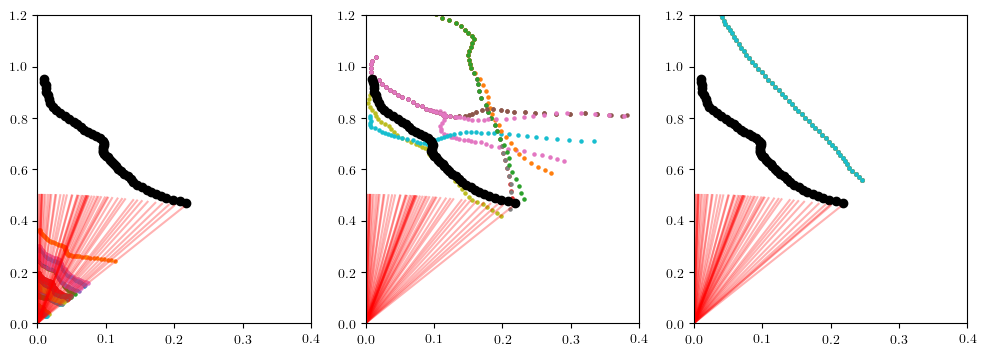

(0.0, 1.2)

In [234]:
figure(figsize=(12,4))

function set_lim()
    gca()[:set_xlim]((0., 0.4))
    gca()[:set_ylim]((0., 1.2)) 
end

subplot(1, 3, 1)
overlay(render, pf_with_rejuv_traces, same_data=true)
scatter(xs, ys, color="black")
set_lim()

subplot(1, 3, 2)
overlay(render, pf_traces, same_data=true)
scatter(xs, ys, color="black")
set_lim()

subplot(1, 3, 3)
overlay(render, importance_traces, same_data=true)
scatter(xs, ys, color="black")
set_lim()